In [1]:
# Computing Volatitlity

In [5]:
# Importing Packages
import math
import numpy as np
import yfinance as yf

In [16]:
# Importing Stock Price
data = yf.download("TSLA",start='2018-01-01',end='2022-12-07')

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

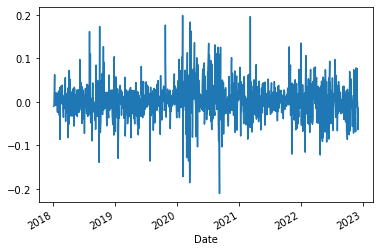

In [23]:
# Ploting the Closing Prices
data['Close'].pct_change().plot()

<AxesSubplot:xlabel='Date'>

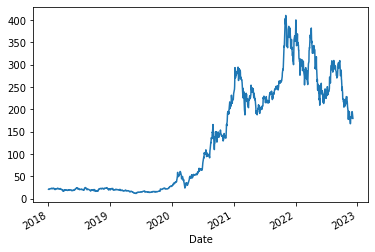

In [24]:
data['Close'].plot()

<AxesSubplot:xlabel='Date'>

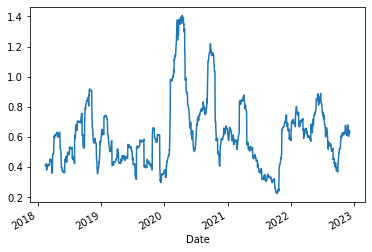

In [18]:
# Calculating and Ploting the Standard Deviation
## Standard deviation measures how widely returns are dispersed from the average return.
## It’s the most common (and biased) estimator of volatility.
def standard_deviation(price_data, window=30, trading_periods=252, clean=True):

    log_return = (price_data["Close"] / price_data["Close"].shift(1)).apply(np.log)

    result = log_return.rolling(window=window, center=False).std() * math.sqrt(
        trading_periods
    )

    if clean:
        return result.dropna()
    else:
        return result
    
standard_deviation(data).plot()

<AxesSubplot:xlabel='Date'>

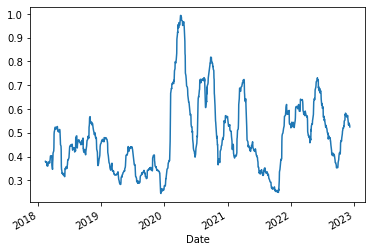

In [19]:
# Parkinson
## Parkinson’s volatility uses the stock’s high and low price of the day rather 
## than just close to close prices. It’s useful to capture large price movements during the 
## day.

def parkinson(price_data, window=30, trading_periods=252, clean=True):

    rs = (1.0 / (4.0 * math.log(2.0))) * (
        (price_data["High"] / price_data["Low"]).apply(np.log)
    ) ** 2.0

    def f(v):
        return (trading_periods * v.mean()) ** 0.5

    result = rs.rolling(window=window, center=False).apply(func=f)

    if clean:
        return result.dropna()
    else:
        return result

parkinson(data).plot()

<AxesSubplot:xlabel='Date'>

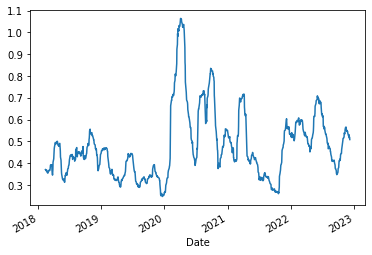

In [20]:
# German-Klass
## Garman-Klass volatility extends Parkinson’s volatility by taking into account the 
## opening and closing price. As markets are most active during the opening and 
## closing of a trading session, it makes volatility estimation more accurate.

def garman_klass(price_data, window=30, trading_periods=252, clean=True):

    log_hl = (price_data["High"] / price_data["Low"]).apply(np.log)
    log_co = (price_data["Close"] / price_data["Open"]).apply(np.log)

    rs = 0.5 * log_hl ** 2 - (2 * math.log(2) - 1) * log_co ** 2

    def f(v):
        return (trading_periods * v.mean()) ** 0.5

    result = rs.rolling(window=window, center=False).apply(func=f)

    if clean:
        return result.dropna()
    else:
        return result


garman_klass(data).plot()

<AxesSubplot:xlabel='Date'>

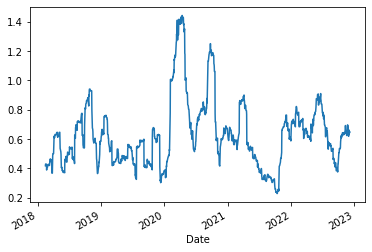

In [21]:
# Hodges-Tompkins
## Hodges-Tompkins volatility is a bias correction for estimation using an overlapping data
## sample that produces unbiased estimates and a substantial gain in efficiency.

def hodges_tompkins(price_data, window=30, trading_periods=252, clean=True):

    log_return = (price_data["Close"] / price_data["Close"].shift(1)).apply(np.log)

    vol = log_return.rolling(window=window, center=False).std() * math.sqrt(
        trading_periods
    )

    h = window
    n = (log_return.count() - h) + 1

    adj_factor = 1.0 / (1.0 - (h / n) + ((h ** 2 - 1) / (3 * n ** 2)))

    result = vol * adj_factor

    if clean:
        return result.dropna()
    else:
        return

hodges_tompkins(data).plot()

<AxesSubplot:xlabel='Date'>

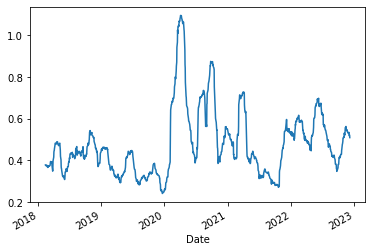

In [25]:
# Rogers-Satchell
## Rogers-Satchell is an estimator for measuring the volatility of securities with an average
## return not equal to zero. Unlike Parkinson and Garman-Klass estimators, Rogers-Satchell 
## incorporates a drift term (mean return not equal to zero).
def rogers_satchell(price_data, window=30, trading_periods=252, clean=True):

    log_ho = (price_data["High"] / price_data["Open"]).apply(np.log)
    log_lo = (price_data["Low"] / price_data["Open"]).apply(np.log)
    log_co = (price_data["Close"] / price_data["Open"]).apply(np.log)

    rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)

    def f(v):
        return (trading_periods * v.mean()) ** 0.5

    result = rs.rolling(window=window, center=False).apply(func=f)

    if clean:
        return result.dropna()
    else:
        return result

rogers_satchell(data).plot()


<AxesSubplot:xlabel='Date'>

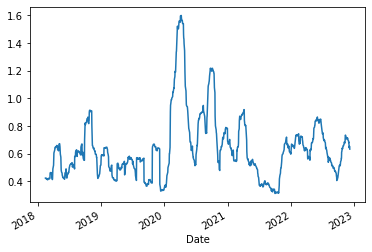

In [26]:
# Yang-Zhang
## Yang-Zhang volatility is the combination of the overnight (close-to-open volatility), 
## a weighted average of the Rogers-Satchell volatility and the day’s open-to-close 
## volatility.

def yang_zhang(price_data, window=30, trading_periods=252, clean=True):

    log_ho = (price_data["High"] / price_data["Open"]).apply(np.log)
    log_lo = (price_data["Low"] / price_data["Open"]).apply(np.log)
    log_co = (price_data["Close"] / price_data["Open"]).apply(np.log)

    log_oc = (price_data["Open"] / price_data["Close"].shift(1)).apply(np.log)
    log_oc_sq = log_oc ** 2

    log_cc = (price_data["Close"] / price_data["Close"].shift(1)).apply(np.log)
    log_cc_sq = log_cc ** 2

    rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)

    close_vol = log_cc_sq.rolling(window=window, center=False).sum() * (
        1.0 / (window - 1.0)
    )
    open_vol = log_oc_sq.rolling(window=window, center=False).sum() * (
        1.0 / (window - 1.0)
    )
    window_rs = rs.rolling(window=window, center=False).sum() * (1.0 / (window - 1.0))

    k = 0.34 / (1.34 + (window + 1) / (window - 1))
    result = (open_vol + k * close_vol + (1 - k) * window_rs).apply(
        np.sqrt
    ) * math.sqrt(trading_periods)

    if clean:
        return result.dropna()
    else:
        return result

yang_zhang(data).plot()
